In [1]:
import numpy as np
import data_loading

In [2]:
gamma_ts.shape, percentile_rank_chars.shape

NameError: name 'gamma_ts' is not defined

In [3]:

percentile_rank_chars, regular_chars, chars, dates,\
    return_panel, permnos, rts, monthly_updates = data_loading.get_data_panel("../Data/raw_chars_returns_df_all_dates_yearly_fb.fthr",
                                                            "../Data/ff_rf.csv", computstat_data_present_filter=True,
                                                                              financial_firm_filter=False)

Index(['A2ME', 'AC', 'AT', 'ATO', 'B2M', 'BETA_d', 'BETA_m', 'C2A', 'CF2B',
       'CF2P', 'CTO', 'D2A', 'D2P', 'DPI2A', 'E2P', 'FC2Y', 'HIGH52', 'INV',
       'IdioVol', 'LEV', 'ME', 'NI', 'NOA', 'OA', 'OL', 'OP', 'PCM', 'PM',
       'PROF', 'Q', 'R12_2', 'R12_7', 'R2_1', 'R36_13', 'R60_13', 'RNA', 'ROA',
       'ROE', 'RVAR', 'S2P', 'SGA2S', 'SPREAD', 'SUV', 'TURN', 'VAR', 'return',
       'date', 'permno', 'monthly_update'],
      dtype='object')
['A2ME' 'AC' 'AT' 'ATO' 'B2M' 'BETA_d' 'BETA_m' 'C2A' 'CF2B' 'CF2P' 'CTO'
 'D2A' 'D2P' 'DPI2A' 'E2P' 'FC2Y' 'HIGH52' 'INV' 'IdioVol' 'LEV' 'ME' 'NI'
 'NOA' 'OA' 'OL' 'OP' 'PCM' 'PM' 'PROF' 'Q' 'R12_2' 'R12_7' 'R2_1'
 'R36_13' 'R60_13' 'RNA' 'ROA' 'ROE' 'RVAR' 'S2P' 'SGA2S' 'SPREAD' 'SUV'
 'TURN' 'VAR']


 25%|██████████████████▊                                                         | 160/648 [00:22<01:07,  7.20it/s]


KeyboardInterrupt: 

In [ ]:
gamma_ts = np.load('../Data/gamma_ts_save.npz')['data']

In [ ]:
from tqdm import tqdm

In [ ]:
import importlib

In [25]:
importlib.reload(data_loading)

<module 'data_loading' from '/home/selwin_p_george/CS 236 Project/Code/data_loading.py'>

In [146]:
all_data = data_loading.get_data(percentile_rank_chars*.99 + 0.5, 30, fill_val=-1)

100%|███████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 804.64it/s]


In [94]:
np.nanmin([np.nanmin(x[3]) for x in all_data])

-1.0

In [152]:
importlib.reload(data_loading)

<module 'data_loading' from '/home/selwin_p_george/CS 236 Project/Code/data_loading.py'>

In [20]:
all_dataset = data_loading.ListDataset(all_data, batch_size=15)
train_data_loader = data_loading.DataLoader(all_dataset, batch_size=100, shuffle=True, num_workers=4)

ValueError: too many values to unpack (expected 5)

In [27]:
from torch.optim.lr_scheduler import MultiStepLR
import time

In [34]:
import models, loss_functions

In [158]:
importlib.reload(data_loading)

<module 'data_loading' from '/home/selwin_p_george/CS 236 Project/Code/data_loading.py'>

In [172]:
from tqdm.notebook import tqdm

In [177]:
model = models.CharLSTM(input_dim=90, batch_size=100, num_layers=1)

num_epochs = 21
eval_freq = 10

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


scheduler = MultiStepLR(optimizer, [20, 30], gamma=0.1, last_epoch=-1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f'torch device is {device}')
model = model.to(device)
loss_fn = loss_functions.beta_ll_loss


#basic training loop for local development
for epoch in range(num_epochs):
    epoch_start = time.time()
    losses = []
    # Forward pass
    print(f'epoch {epoch}')
    for i, data in enumerate(tqdm(train_data_loader)):
        model.batch_size = data[0].shape[0]
#         print(data[0].shape)
        assert not torch.isnan(data[0]).any()
        assert not torch.isnan(data[1]).any()
        C_train, C_mask = data
        C_train = C_train.float().to(device)
        C_mask = C_mask.float().to(device)
        C_mask = C_mask.transpose_(0, 1)
        C_train = C_train.transpose_(0, 1)
        train_input = torch.cat([C_train, C_mask], axis=2)
#       
#         print(train_input.shape)
        alpha_pred, beta_pred = model(train_input)

        loss = loss_fn(C_train[1:], alpha_pred[:-1], beta_pred[:-1], mask=C_mask[1:]).mean()
        if i % 100 == 0:
            print(loss)
            
        
        loss.backward()
#         for param in model.parameters():
#             print(param, param.grad.view(-1))
        losses.append(loss.data.cpu().numpy())
        
        if i % 10 == 0:
            optimizer.step()
            model.zero_grad()
            optimizer.zero_grad()       
            
        
    print(f'epoch {epoch} avg loss {np.mean(losses)}')
    print(f'epoch {epoch} took {(time.time() - epoch_start)/60.0} minutes')
    scheduler.step()

torch device is cuda:0
epoch 0


  0%|          | 0/1101 [00:00<?, ?it/s]

tensor(54.0304, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(53.5165, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(57.2412, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(55.7064, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(47.2388, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(49.2795, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(50.5348, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(44.5951, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(39.3721, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(35.7045, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(35.4122, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(27.6264, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 avg loss 46.60236358642578
epoch 0 took 0.15679577191670735 minutes
epoch 1


  0%|          | 0/1101 [00:00<?, ?it/s]

tensor(28.8353, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(24.0346, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(26.5444, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(19.6423, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(18.7754, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.6418, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.6277, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.8567, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.5585, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.8568, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2097, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5190, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 1 avg loss 15.513772964477539
epoch 1 took 0.15573090314865112 minutes
epoch 2


  0%|          | 0/1101 [00:00<?, ?it/s]

tensor(6.7042, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.8026, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.0633, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.3649, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7901, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.9648, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7106, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3029, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2.0304, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2.1664, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3.0205, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 2 avg loss 1.0990623235702515
epoch 2 took 0.15624818007151287 minutes
epoch 3


  0%|          | 0/1101 [00:00<?, ?it/s]

tensor(0.1271, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2.3415, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2.9773, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3.6850, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4.5724, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3.7035, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3.1071, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3.6383, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3.9068, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4.4441, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5.4376, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4.0616, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 3 avg loss -3.459582805633545
epoch 3 took 0.15859498977661132 minutes
epoch 4


  0%|          | 0/1101 [00:00<?, ?it/s]

tensor(-3.5983, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4.2969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4.0411, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5.2981, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4.7739, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4.7599, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3.9122, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5.5110, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5.6843, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5.8773, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5.0011, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5.8762, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 4 avg loss -5.246487617492676
epoch 4 took 0.15969153642654418 minutes
epoch 5


  0%|          | 0/1101 [00:00<?, ?it/s]

tensor(-5.5948, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6.2577, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5.2619, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5.2054, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5.7049, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6.0930, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5.2646, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5.6570, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6.2043, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6.5026, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6.0086, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6.8567, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 5 avg loss -6.141446113586426
epoch 5 took 0.15605331261952718 minutes
epoch 6


  0%|          | 0/1101 [00:00<?, ?it/s]

tensor(-6.4631, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7.0660, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6.6803, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6.6477, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6.8913, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6.7224, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6.2722, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6.2676, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7.9427, device='cuda:0', grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

In [186]:
train_losses = []
train_masks = []
for i, data in enumerate(tqdm(train_data_loader)):
        model.batch_size = data[0].shape[0]
#         print(data[0].shape)
        assert not torch.isnan(data[0]).any()
        assert not torch.isnan(data[1]).any()
        C_train, C_mask = data
        C_train = C_train.float().to(device)
        C_mask = C_mask.float().to(device)
        C_mask = C_mask.transpose_(0, 1)
        C_train = C_train.transpose_(0, 1)
        train_input = torch.cat([C_train, C_mask], axis=2)
#       
#         print(train_input.shape)
        alpha_pred, beta_pred = model(train_input)    
        loss = torch.square(C_train[1:] - (alpha_pred / (alpha_pred + beta_pred))[:-1])
        train_losses.append(loss.detach().cpu().numpy())
        train_masks.append(C_mask[1:].detach().cpu().numpy())

  0%|          | 0/1101 [00:00<?, ?it/s]

In [191]:
train_masks = np.concatenate(train_masks, axis=1)

In [192]:
train_masks.shape

(14, 110075, 45)

In [196]:
np.sqrt(np.sum(np.concatenate(train_losses, axis=1)*(1-train_masks)) / np.sum(1-train_masks))

0.24598782

In [ ]:
loss_matrix = np.swapaxes(np.array(train_losses), 1,2).reshape((557 * 10, 49, 45))
for j in range(5):
    plt.figure(figsize=(20,10))
    for i in range(j*9, (j+1)*9):
        plt.plot(np.sqrt(np.mean(loss_matrix[:,:,i], axis=0)), label=chars[i])
    plt.legend()
    plt.show()

In [72]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan

In [68]:
losses

[array(41.88462, dtype=float32)]

In [104]:
train_losses = []
for i, data in enumerate(tqdm(train_data_loader)):
    assert not torch.isnan(data).any()
    assert not (data <= 0).any(), torch.min(data)
    C_train = data 
    C_train = C_train.transpose_(0, 1)
#         print(C_train)
    C_train = C_train.float().to(device)        
    alpha_pred, beta_pred = model(C_train)
#         print(type(C_train), type(alpha_pred), type(beta_pred))
#         print(C_train.shape, alpha_pred.shape, beta_pred.shape)
    loss = rmmse(C_train[1:], alpha_pred[:-1], beta_pred[:-1]).mean()
    train_losses.append(loss.detach().numpy())

100%|██████████| 6588/6588 [01:32<00:00, 71.31it/s] 


In [87]:
import matplotlib.pyplot as plt

In [105]:
np.mean(train_losses)

0.27016738

(array([  51.,  462., 1238., 1681., 1452.,  875.,  503.,  231.,   82.,
          13.]),
 array([0.1677058 , 0.19280942, 0.21791303, 0.24301666, 0.26812026,
        0.2932239 , 0.31832752, 0.34343112, 0.36853474, 0.39363834,
        0.41874197], dtype=float32),
 <BarContainer object of 10 artists>)

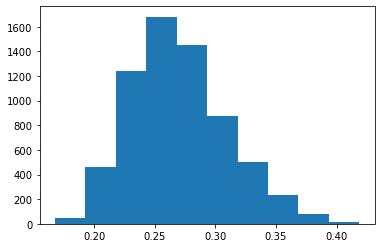

In [106]:
plt.hist(np.array(train_losses).squeeze())

(array([  21.,  372., 1388., 1965., 1476.,  811.,  345.,  160.,   43.,
           7.]),
 array([0.10431888, 0.12601776, 0.14771666, 0.16941553, 0.19111443,
        0.21281332, 0.2345122 , 0.2562111 , 0.27790996, 0.29960886,
        0.32130775], dtype=float32),
 <BarContainer object of 10 artists>)

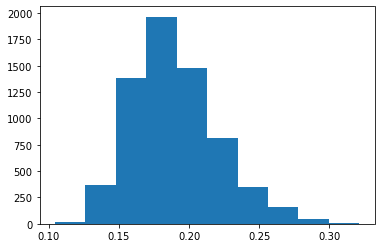

In [95]:
plt.hist(np.array(train_losses).squeeze())

In [1]:
import numpy as np
import csv
import pandas as pd
import torch
import torch.nn as nn
import data_loading

In [2]:

percentile_rank_chars, _, chars, _,\
    _, _, _, _ = data_loading.get_data_panel("../Data/raw_chars_returns_df_all_dates_yearly_fb.fthr",
                                                            "../Data/ff_rf.csv", computstat_data_present_filter=True,
                                                                              financial_firm_filter=False)

Index(['A2ME', 'AC', 'AT', 'ATO', 'B2M', 'BETA_d', 'BETA_m', 'C2A', 'CF2B',
       'CF2P', 'CTO', 'D2A', 'D2P', 'DPI2A', 'E2P', 'FC2Y', 'HIGH52', 'INV',
       'IdioVol', 'LEV', 'ME', 'NI', 'NOA', 'OA', 'OL', 'OP', 'PCM', 'PM',
       'PROF', 'Q', 'R12_2', 'R12_7', 'R2_1', 'R36_13', 'R60_13', 'RNA', 'ROA',
       'ROE', 'RVAR', 'S2P', 'SGA2S', 'SPREAD', 'SUV', 'TURN', 'VAR', 'return',
       'date', 'permno', 'monthly_update'],
      dtype='object')
['A2ME' 'AC' 'AT' 'ATO' 'B2M' 'BETA_d' 'BETA_m' 'C2A' 'CF2B' 'CF2P' 'CTO'
 'D2A' 'D2P' 'DPI2A' 'E2P' 'FC2Y' 'HIGH52' 'INV' 'IdioVol' 'LEV' 'ME' 'NI'
 'NOA' 'OA' 'OL' 'OP' 'PCM' 'PM' 'PROF' 'Q' 'R12_2' 'R12_7' 'R2_1'
 'R36_13' 'R60_13' 'RNA' 'ROA' 'ROE' 'RVAR' 'S2P' 'SGA2S' 'SPREAD' 'SUV'
 'TURN' 'VAR']


100%|████████████████████████████████████████████████████████████████████████████| 648/648 [03:02<00:00,  3.56it/s]


In [3]:
np.nanmax(percentile_rank_chars*.99 + 0.5)

0.995

In [4]:
import importlib
importlib.reload(data_loading)

<module 'data_loading' from '/home/selwin_p_george/CS 236 Project/Code/data_loading.py'>

In [7]:
all_data = data_loading.get_data(percentile_rank_chars, 10, fill_val=-1, gamma_ts=gamma_ts, ordered=False)

100%|████████████████████████████████████████████████████████████████████████████| 648/648 [00:17<00:00, 36.62it/s]


In [6]:
gamma_ts = np.load('../Data/gamma_ts_save.npz')['data']

In [18]:
import importlib
importlib.reload(models)

<module 'models' from '/home/selwin_p_george/CS 236 Project/Code/models.py'>

In [61]:
1

1

In [9]:
len(all_dataset)

34035

In [10]:
from tqdm.notebook import tqdm

In [11]:
import loss_functions

In [12]:
import models

In [13]:
from torch.optim.lr_scheduler import MultiStepLR
import time

In [1]:
import importlib
importlib.reload(models)

NameError: name 'models' is not defined

In [58]:
batch_size = 50
all_dataset = data_loading.ListDatasetWithFactors(all_data, batch_size=50)
train_data_loader = data_loading.DataLoader(all_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
model = models.XSCharLSTM(input_dim=96, hidden_dims=[20, 10], num_layers=4, batch_size=batch_size)

num_epochs = 41
eval_freq = 10

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


scheduler = MultiStepLR(optimizer, [20, 30], gamma=0.1, last_epoch=-1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'torch device is {device}')
model = model.to(device)
loss_fn = loss_functions.beta_ll_loss


#basic training loop for local development
for epoch in range(num_epochs):
    epoch_start = time.time()
    losses = []
    # Forward pass
    print(f'epoch {epoch}')
    for i, data in enumerate(tqdm(train_data_loader)):
        data, mask, ordered_mask, factors = data
        assert not torch.isnan(data).any()
#         assert not (data <= 0).any(), torch.min(data)
#         print(data.shape)
        C_train = data.transpose_(0, 1).float().to(device)[:-1]
        
        C_mask = mask.float().to(device).transpose_(0, 1)[:-1]
        C_ordered_mask = ordered_mask.float().to(device).transpose_(0, 1)[:-1]
        
        factors = factors.transpose_(0, 1).float().to(device)[1:]
        
        train_input = torch.cat([C_train, C_mask, factors], axis=2)
        
        if train_input.shape[1] == batch_size and train_input.shape[2] > 0:
#             print(train_input.shape)
            alpha_pred, beta_pred, hidden_out = model(train_input)
#             print(hidden_out.shape)

            loss = loss_fn(C_train[1:], alpha_pred[:-1], beta_pred[:-1], mask=C_mask[1:]).mean()
            assert not torch.isnan(loss).any()

            loss.backward()
            losses.append(loss.data.cpu().detach().numpy())

            optimizer.step()
            model.zero_grad()
            optimizer.zero_grad()       


    print(f'epoch {epoch} avg loss {np.mean(losses)}')
    print(f'epoch {epoch} took {(time.time() - epoch_start)/60.0} minutes')
    scheduler.step()

epoch 17


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 17 avg loss -25.475017547607422
epoch 17 took 0.3013657808303833 minutes
epoch 18


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 18 avg loss -26.05698013305664
epoch 18 took 0.3031572182973226 minutes
epoch 19


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 19 avg loss -27.158912658691406
epoch 19 took 0.30062798659006756 minutes
epoch 20


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 20 avg loss -28.23035430908203
epoch 20 took 0.30330244700113934 minutes
epoch 21


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 21 avg loss -28.33894157409668
epoch 21 took 0.30254422426223754 minutes
epoch 22


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 22 avg loss -28.417922973632812
epoch 22 took 0.3024233976999919 minutes
epoch 23


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 23 avg loss -28.49239158630371
epoch 23 took 0.30202861229578654 minutes
epoch 24


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 24 avg loss -28.561368942260742
epoch 24 took 0.30075633923212686 minutes
epoch 25


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 25 avg loss -28.621570587158203
epoch 25 took 0.2995798985163371 minutes
epoch 26


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 26 avg loss -28.67874526977539
epoch 26 took 0.3000262022018433 minutes
epoch 27


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 27 avg loss -28.733415603637695
epoch 27 took 0.30092324018478395 minutes
epoch 28


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 28 avg loss -28.785018920898438
epoch 28 took 0.3006481488545736 minutes
epoch 29


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 29 avg loss -28.8432674407959
epoch 29 took 0.2995431502660116 minutes
epoch 30


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 30 avg loss -28.93024444580078
epoch 30 took 0.3002698302268982 minutes
epoch 31


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 31 avg loss -28.94380760192871
epoch 31 took 0.29997780323028567 minutes
epoch 32


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 32 avg loss -28.94814109802246
epoch 32 took 0.2982035001118978 minutes
epoch 33


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 33 avg loss -28.95203399658203
epoch 33 took 0.3024042367935181 minutes
epoch 34


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 34 avg loss -28.96002769470215
epoch 34 took 0.29957857926686604 minutes
epoch 35


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 35 avg loss -28.968538284301758
epoch 35 took 0.3005855480829875 minutes
epoch 36


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 36 avg loss -28.975637435913086
epoch 36 took 0.3006170471509298 minutes
epoch 37


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 37 avg loss -28.98208236694336
epoch 37 took 0.2992805083592733 minutes
epoch 38


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 38 avg loss -28.980825424194336
epoch 38 took 0.3019334276517232 minutes
epoch 39


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 39 avg loss -28.99110984802246
epoch 39 took 0.3018526593844096 minutes
epoch 40


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 40 avg loss -28.997352600097656
epoch 40 took 0.30104238986968995 minutes


In [59]:
preds = []
gts = []
train_masks = []
for i, data in enumerate(tqdm(train_data_loader)):
    data, mask, ordered_mask, factors = data
    assert not torch.isnan(data).any()
#         assert not (data <= 0).any(), torch.min(data)
#         print(data.shape)
    C_train = data.transpose_(0, 1).float().to(device)[:-1]
        
    C_mask = mask.float().to(device).transpose_(0, 1)[:-1]
    C_ordered_mask = ordered_mask.float().to(device).transpose_(0, 1)[:-1]

    factors = factors.transpose_(0, 1).float().to(device)[1:]

    train_input = torch.cat([C_train, C_mask, factors], axis=2)       
    if train_input.shape[1] == batch_size:
        alpha_pred, beta_pred,_ = model(train_input)

        pred = alpha_pred / (alpha_pred + beta_pred)
        preds.append(pred.detach().cpu().numpy())
        gts.append(C_train.detach().cpu().numpy())
        train_masks.append(C_mask.detach().cpu().numpy())

preds = np.concatenate(preds, axis=0)
gts = np.concatenate(gts, axis=0)
train_masks = np.concatenate(train_masks, axis=0)
gts[train_masks == 1] = np.nan

mse = np.nanmean((preds - gts)**2, axis=(0,1))
list(zip(chars, np.sqrt(mse))), np.mean(np.sqrt(mse))

  0%|          | 0/681 [00:00<?, ?it/s]

([('A2ME', 0.050289903),
  ('AC', 0.27949667),
  ('AT', 0.035588104),
  ('ATO', 0.16130082),
  ('B2M', 0.076287664),
  ('BETA_d', 0.2166461),
  ('BETA_m', 0.25594813),
  ('C2A', 0.18278451),
  ('CF2B', 0.25023016),
  ('CF2P', 0.1935138),
  ('CTO', 0.06814208),
  ('D2A', 0.2531572),
  ('D2P', 0.24935588),
  ('DPI2A', 0.2725244),
  ('E2P', 0.18773198),
  ('FC2Y', 0.082171746),
  ('HIGH52', 0.24069962),
  ('INV', 0.25916213),
  ('IdioVol', 0.12342199),
  ('LEV', 0.095899776),
  ('ME', 0.024728965),
  ('NI', 0.27042404),
  ('NOA', 0.09452755),
  ('OA', 0.28258958),
  ('OL', 0.06582625),
  ('OP', 0.17795268),
  ('PCM', 0.15147145),
  ('PM', 0.1344817),
  ('PROF', 0.163332),
  ('Q', 0.061229687),
  ('R12_2', 0.2476293),
  ('R12_7', 0.2596719),
  ('R2_1', 0.28367975),
  ('R36_13', 0.2604892),
  ('R60_13', 0.2533924),
  ('RNA', 0.17437664),
  ('ROA', 0.19866456),
  ('ROE', 0.2199848),
  ('RVAR', 0.12825903),
  ('S2P', 0.057924397),
  ('SGA2S', 0.07469727),
  ('SPREAD', 0.18545642),
  ('SUV', 0

In [52]:
np.sqrt(np.mean(mse))

0.2232493

In [258]:
np.array(train_losses).shape

(557, 49, 10, 45)

In [259]:
loss_matrix = np.swapaxes(np.array(train_losses), 1,2).reshape((557 * 10, 49, 45))

In [260]:
loss_matrix.shape

(5570, 49, 45)

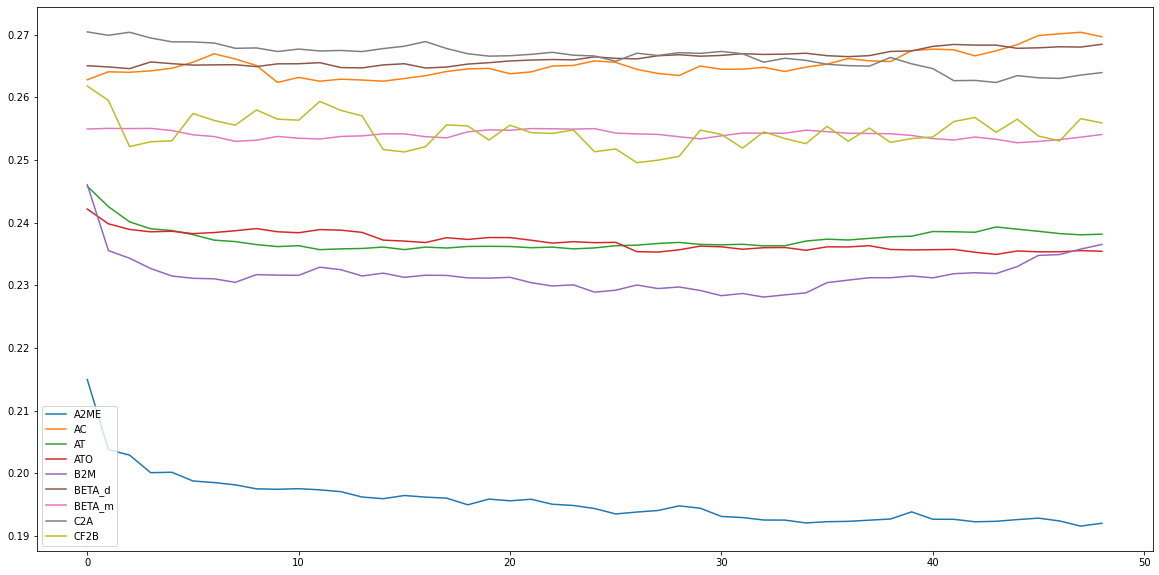

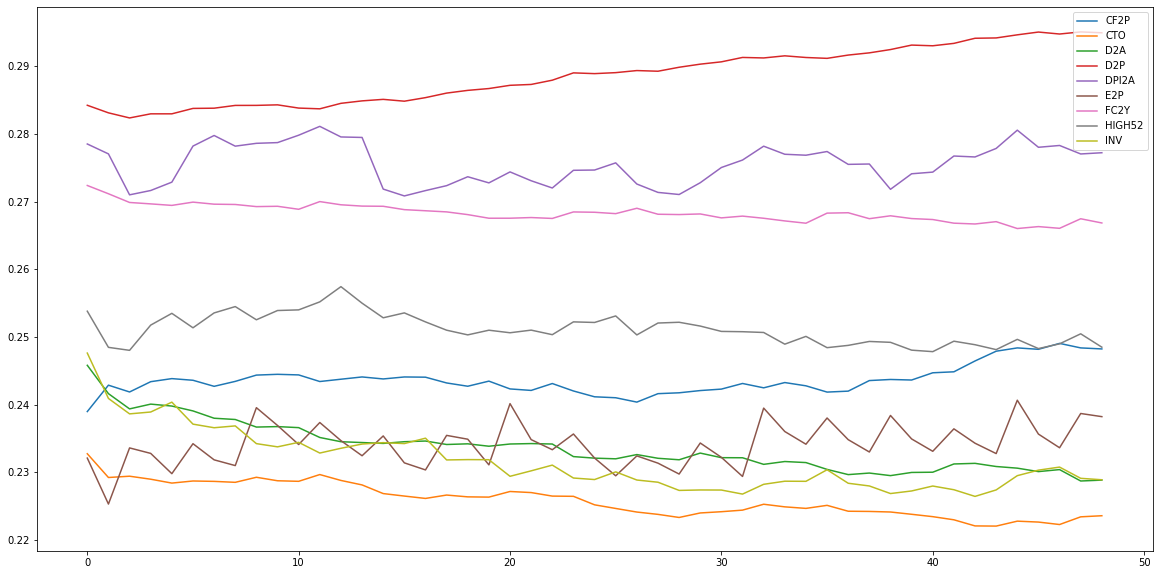

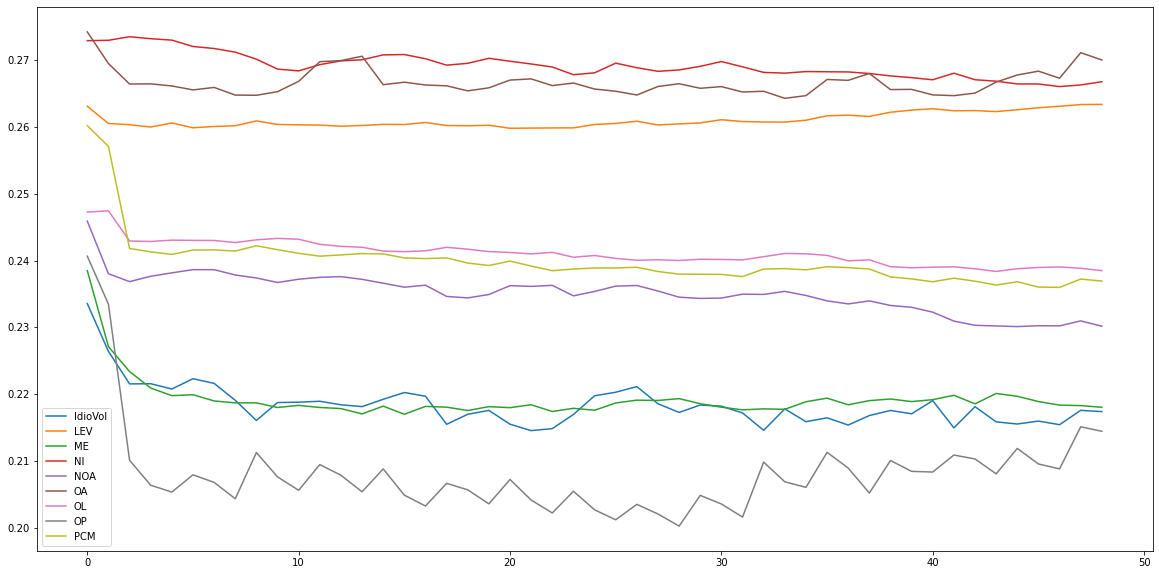

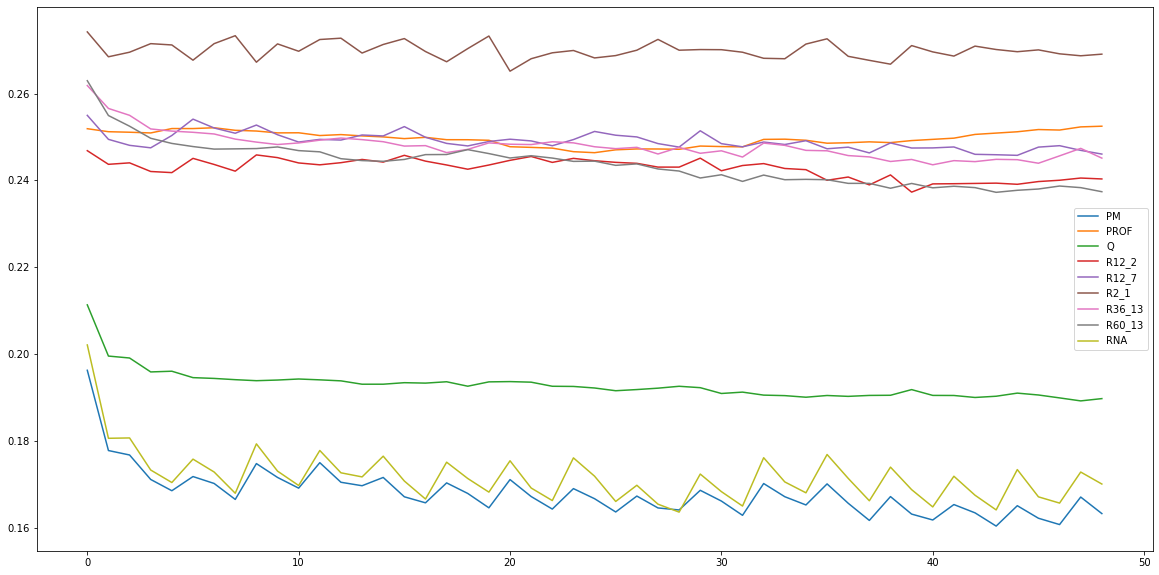

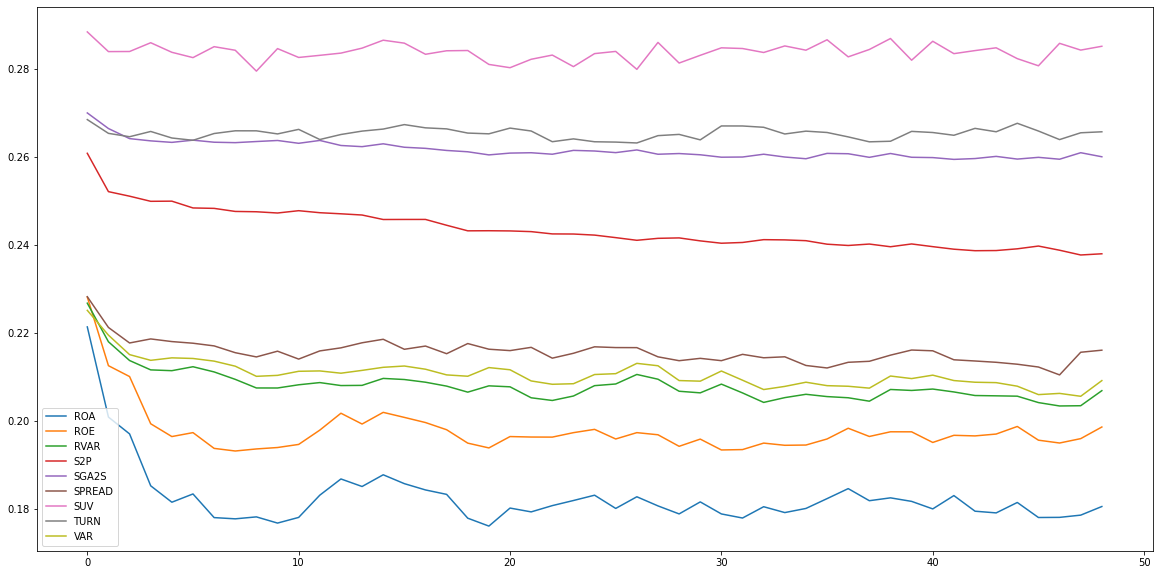

In [261]:
for j in range(5):
    plt.figure(figsize=(20,10))
    for i in range(j*9, (j+1)*9):
        plt.plot(np.sqrt(np.mean(loss_matrix[:,:,i], axis=0)), label=chars[i])
    plt.legend()
    plt.show()

In [182]:
model = models.XSCharLSTM(hiddin_dim=15, num_layers=2, batch_size=10)

num_epochs = 21
eval_freq = 10

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


scheduler = MultiStepLR(optimizer, [10, 20], gamma=0.1, last_epoch=-1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'torch device is {device}')
model = model.to(device)
loss_fn = beta_ll_loss


#basic training loop for local development
for epoch in range(num_epochs):
    epoch_start = time.time()
    losses = []
    # Forward pass
    print(f'epoch {epoch}')
    for i, data in enumerate(tqdm(train_data_loader)):
        data, factors = data
        assert not torch.isnan(data).any()
        assert not (data <= 0).any(), torch.min(data)
        input_train = torch.cat([data, factors*0], dim=2)
        
        input_train = input_train.transpose_(0, 1).float().to(device)        
#         print(C_train)
        C_train = data.transpose_(0, 1).float().to(device)        
        if input_train.shape[1] == 10:
            alpha_pred, beta_pred = model(input_train)
    #         print(type(C_train), type(alpha_pred), type(beta_pred))
    #         print(C_train.shape, alpha_pred.shape, beta_pred.shape)
            loss = loss_fn(C_train[1:], alpha_pred[:-1], beta_pred[:-1]).mean()
            assert not torch.isnan(loss).any()
    #         if i % 100 == 0:
    #             print(loss)
    #             print(C_train.shape)
            loss.backward()
            losses.append(loss.data.numpy())
    #         assert not torch.isnan(model.alpha_lstm.grad).any()
    #         
            if i % 10 == 0:
    #             torch.nn.utils.clip_grad_norm_(model.parameters(), 50)
                optimizer.step()
                model.zero_grad()
                optimizer.zero_grad()       


    print(f'epoch {epoch} avg loss {np.mean(losses)}')
    print(f'epoch {epoch} took {(time.time() - epoch_start)/60.0} minutes')
    scheduler.step()

torch device is cpu
epoch 0


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 0 avg loss 406.4643859863281
epoch 0 took 0.21822460095087687 minutes
epoch 1


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 1 avg loss 18.057058334350586
epoch 1 took 0.21013996601104737 minutes
epoch 2


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 2 avg loss 1.0882651805877686
epoch 2 took 0.21185503005981446 minutes
epoch 3


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 3 avg loss -0.8970663547515869
epoch 3 took 0.20812264680862427 minutes
epoch 4


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 4 avg loss -1.307140588760376
epoch 4 took 0.20434724887212116 minutes
epoch 5


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 5 avg loss -1.410843014717102
epoch 5 took 0.20381611982981365 minutes
epoch 6


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 6 avg loss -1.458819031715393
epoch 6 took 0.20502227942148846 minutes
epoch 7


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 7 avg loss -1.4806678295135498
epoch 7 took 0.20251989761988323 minutes
epoch 8


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 8 avg loss -1.5013482570648193
epoch 8 took 0.20333991448084512 minutes
epoch 9


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 9 avg loss -1.5181483030319214
epoch 9 took 0.20218758583068847 minutes
epoch 10


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 10 avg loss -1.533397912979126
epoch 10 took 0.20396481355031332 minutes
epoch 11


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 11 avg loss -1.540582299232483
epoch 11 took 0.2012767195701599 minutes
epoch 12


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 12 avg loss -1.541582465171814
epoch 12 took 0.20162011782328287 minutes
epoch 13


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 13 avg loss -1.5459870100021362
epoch 13 took 0.20255891482035318 minutes
epoch 14


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 14 avg loss -1.5480417013168335
epoch 14 took 0.2007708470026652 minutes
epoch 15


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 15 avg loss -1.5416388511657715
epoch 15 took 0.20115435123443604 minutes
epoch 16


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 16 avg loss -1.5495448112487793
epoch 16 took 0.2010917822519938 minutes
epoch 17


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 17 avg loss -1.553952693939209
epoch 17 took 0.2043400526046753 minutes
epoch 18


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 18 avg loss -1.551073431968689
epoch 18 took 0.2027890165646871 minutes
epoch 19


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 19 avg loss -1.554525375366211
epoch 19 took 0.200555153687795 minutes
epoch 20


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 20 avg loss -1.5593864917755127
epoch 20 took 0.20145464738210042 minutes


In [183]:
train_losses = []
for i, data in enumerate(tqdm(train_data_loader)):
    data, factors = data
    assert not torch.isnan(data).any()
    assert not (data <= 0).any(), torch.min(data)
    input_train = torch.cat([data, factors], dim=2)
    input_train = input_train.transpose_(0, 1).float().to(device)        
#         print(C_train)
    C_train = data.transpose_(0, 1).float().to(device)        
    if input_train.shape[1] == 10:
        alpha_pred, beta_pred = model(input_train)
    #         print(type(C_train), type(alpha_pred), type(beta_pred))
    #         print(C_train.shape, alpha_pred.shape, beta_pred.shape)
        loss = loss_functions.squared_error(C_train[1:], alpha_pred[:-1], beta_pred[:-1])
        train_losses.append(loss.detach().numpy())

  0%|          | 0/558 [00:00<?, ?it/s]

In [184]:
np.sqrt(np.mean(train_losses))

0.2610781

In [185]:
loss_matrix = np.swapaxes(np.array(train_losses), 1,2).reshape((557 * 10, 49, 45))

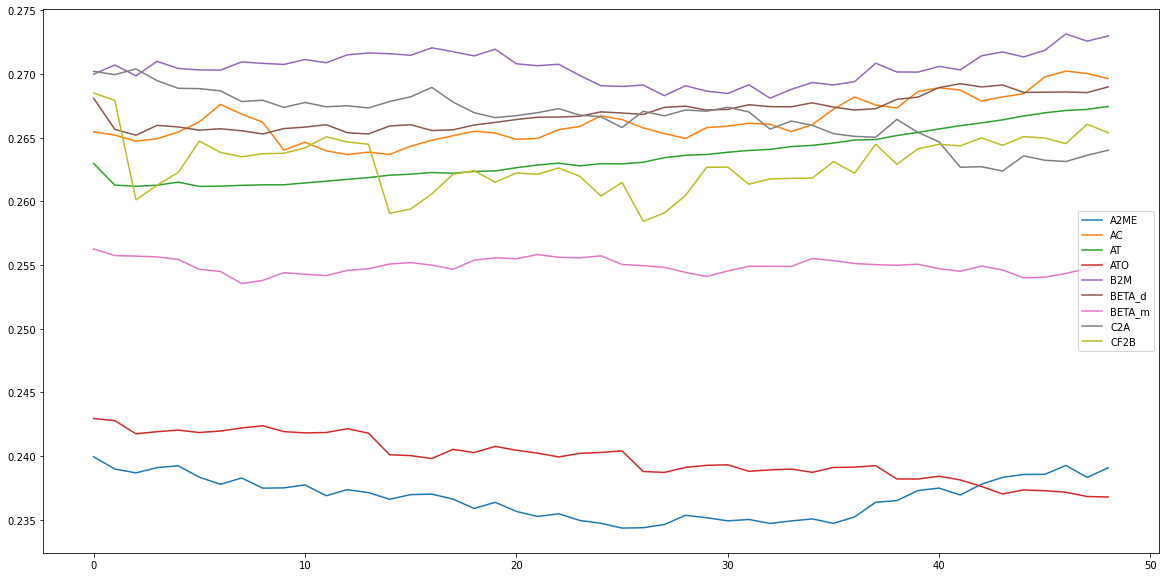

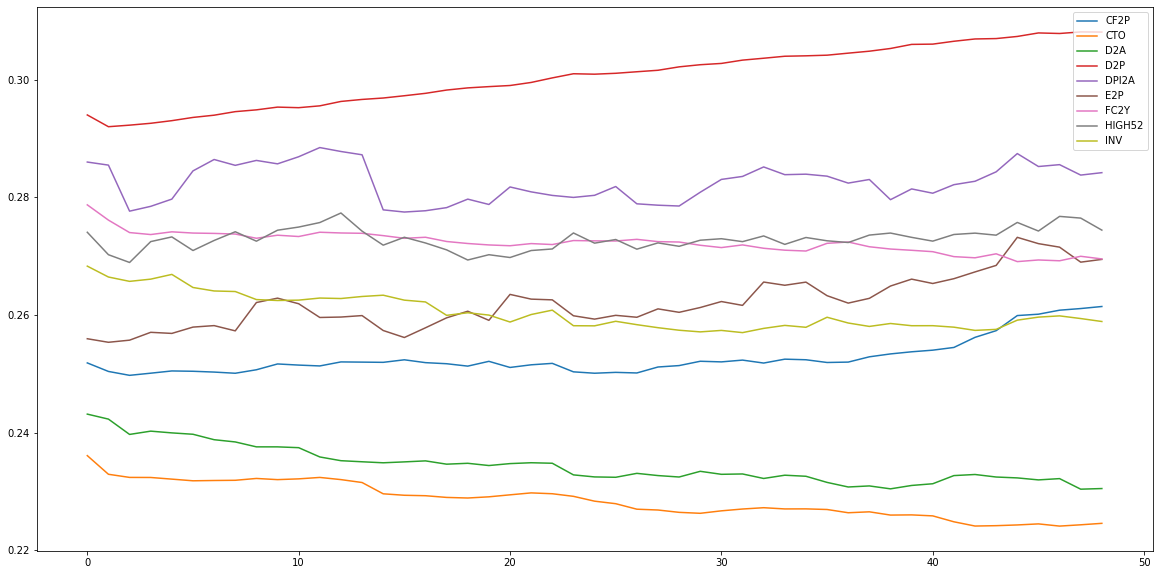

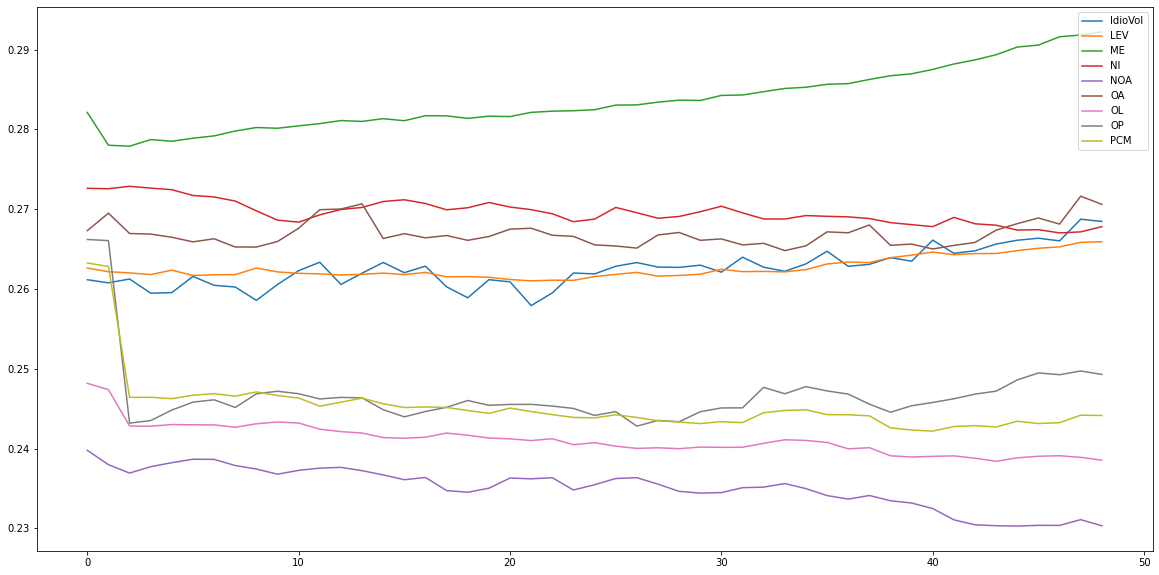

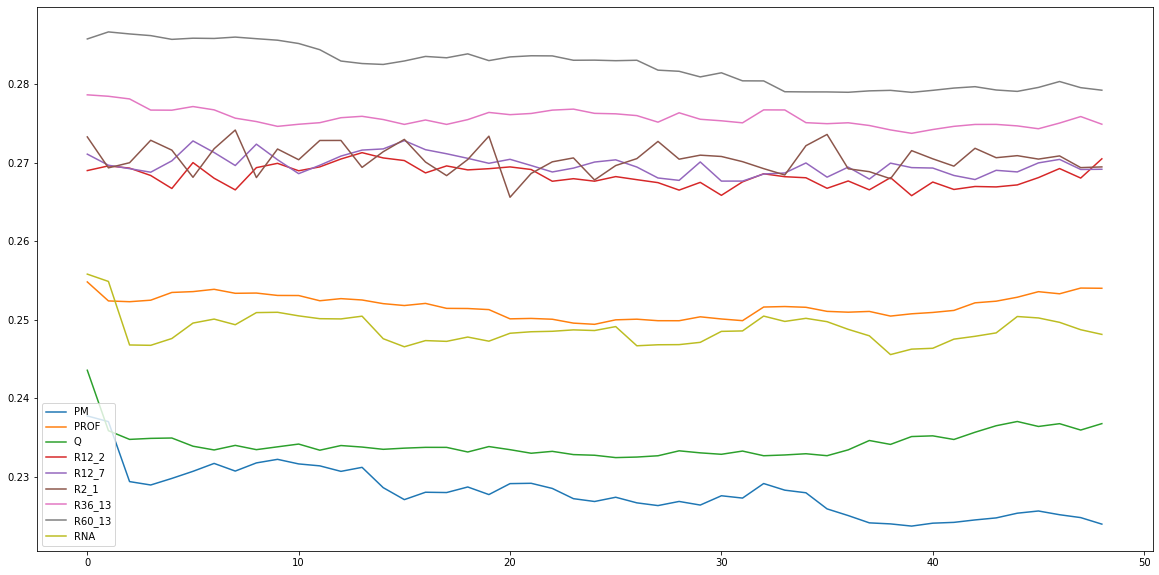

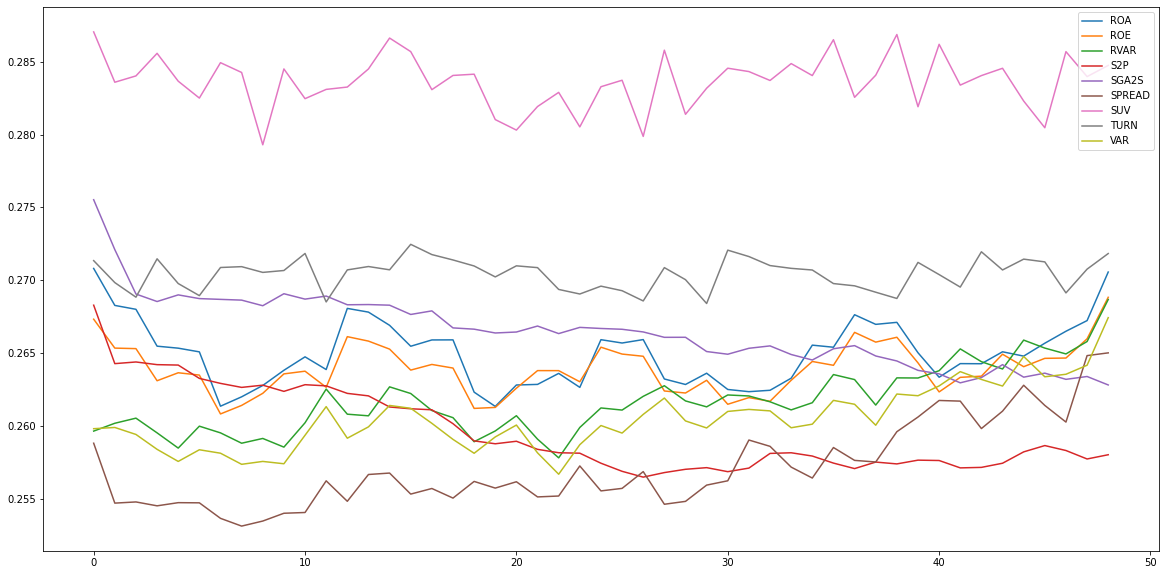

In [186]:
for j in range(5):
    plt.figure(figsize=(20,10))
    for i in range(j*9, (j+1)*9):
        plt.plot(np.sqrt(np.mean(loss_matrix[:,:,i], axis=0)), label=chars[i])
    plt.legend()
    plt.show()

In [230]:
import numpy as np
import csv
import pandas as pd
import torch
import torch.nn as nn


In [232]:
model = XSCharLSTM_V2(hiddin_dim=15, num_layers=2, batch_size=10)

num_epochs = 21
eval_freq = 10

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


scheduler = MultiStepLR(optimizer, [10, 20], gamma=0.1, last_epoch=-1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'torch device is {device}')
model = model.to(device)
loss_fn = beta_ll_loss_mean_scale


#basic training loop for local development
for epoch in range(num_epochs):
    epoch_start = time.time()
    losses = []
    # Forward pass
    print(f'epoch {epoch}')
    for i, data in enumerate(tqdm(train_data_loader)):
        data, factors = data
        assert not torch.isnan(data).any()
        assert not (data <= 0).any(), torch.min(data)
        input_train = torch.cat([data, factors], dim=2)
        
        input_train = input_train.transpose_(0, 1).float().to(device)        
#         print(C_train)
        C_train = data.transpose_(0, 1).float().to(device)        
        if input_train.shape[1] == 10:
            mu_out, scale_out = model(input_train)
    #         print(type(C_train), type(alpha_pred), type(beta_pred))
    #         print(C_train.shape, alpha_pred.shape, beta_pred.shape)
            loss = loss_fn(C_train[1:], mu_out[:-1], scale_out[:-1]).mean()
            assert not torch.isnan(loss).any()
    #         if i % 100 == 0:
    #             print(loss)
    #             print(C_train.shape)
            loss.backward()
            losses.append(loss.data.numpy())
    #         assert not torch.isnan(model.alpha_lstm.grad).any()
    #         
            if i % 10 == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 50)
                optimizer.step()
                model.zero_grad()
                optimizer.zero_grad()       


    print(f'epoch {epoch} avg loss {np.mean(losses)}')
    print(f'epoch {epoch} took {(time.time() - epoch_start)/60.0} minutes')
    scheduler.step()

torch device is cpu
epoch 0


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 0 avg loss 133.6876678466797
epoch 0 took 0.20789304971694947 minutes
epoch 1


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 1 avg loss -1.4309487342834473
epoch 1 took 0.2084904670715332 minutes
epoch 2


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 2 avg loss -1.6370166540145874
epoch 2 took 0.20775134960810343 minutes
epoch 3


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 3 avg loss -1.6789849996566772
epoch 3 took 0.2241727630297343 minutes
epoch 4


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 4 avg loss -1.6604670286178589
epoch 4 took 0.2120333512624105 minutes
epoch 5


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 5 avg loss -1.6731345653533936
epoch 5 took 0.20755195220311481 minutes
epoch 6


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 6 avg loss -1.7030493021011353
epoch 6 took 0.20368026892344157 minutes
epoch 7


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 7 avg loss -1.69850492477417
epoch 7 took 0.205190114180247 minutes
epoch 8


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 8 avg loss -1.7122688293457031
epoch 8 took 0.2035569469134013 minutes
epoch 9


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 9 avg loss -1.715243935585022
epoch 9 took 0.20415135224660239 minutes
epoch 10


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 10 avg loss -1.7724186182022095
epoch 10 took 0.20778290033340455 minutes
epoch 11


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 11 avg loss -1.7888308763504028
epoch 11 took 0.21538788477579754 minutes
epoch 12


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 12 avg loss -1.7901713848114014
epoch 12 took 0.2058664043744405 minutes
epoch 13


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 13 avg loss -1.7878367900848389
epoch 13 took 0.204877765973409 minutes
epoch 14


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 14 avg loss -1.7898756265640259
epoch 14 took 0.203228763739268 minutes
epoch 15


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 15 avg loss -1.791208028793335
epoch 15 took 0.2060472011566162 minutes
epoch 16


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 16 avg loss -1.7881382703781128
epoch 16 took 0.21062333583831788 minutes
epoch 17


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 17 avg loss -1.7912750244140625
epoch 17 took 0.2031245509783427 minutes
epoch 18


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 18 avg loss -1.786044716835022
epoch 18 took 0.20691301425298056 minutes
epoch 19


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 19 avg loss -1.7917581796646118
epoch 19 took 0.20465753078460694 minutes
epoch 20


  0%|          | 0/558 [00:00<?, ?it/s]

epoch 20 avg loss -1.7965495586395264
epoch 20 took 0.20316500266393026 minutes


In [236]:
train_losses = []
for i, data in enumerate(tqdm(train_data_loader)):
    data, factors = data
    assert not torch.isnan(data).any()
    assert not (data <= 0).any(), torch.min(data)
    input_train = torch.cat([data, factors], dim=2)
    input_train = input_train.transpose_(0, 1).float().to(device)        
#         print(C_train)
    C_train = data.transpose_(0, 1).float().to(device)        
    if input_train.shape[1] == 10:
        mu_pred, scale_pred = model(input_train)
    #         print(type(C_train), type(alpha_pred), type(beta_pred))
    #         print(C_train.shape, alpha_pred.shape, beta_pred.shape)
        loss = torch.square(C_train[1:] - mu_pred[:-1])
        train_losses.append(loss.detach().numpy())

  0%|          | 0/558 [00:00<?, ?it/s]

In [237]:
np.sqrt(np.mean(train_losses))

0.26106733

In [238]:
loss_matrix = np.swapaxes(np.array(train_losses), 1,2).reshape((557 * 10, 49, 45))

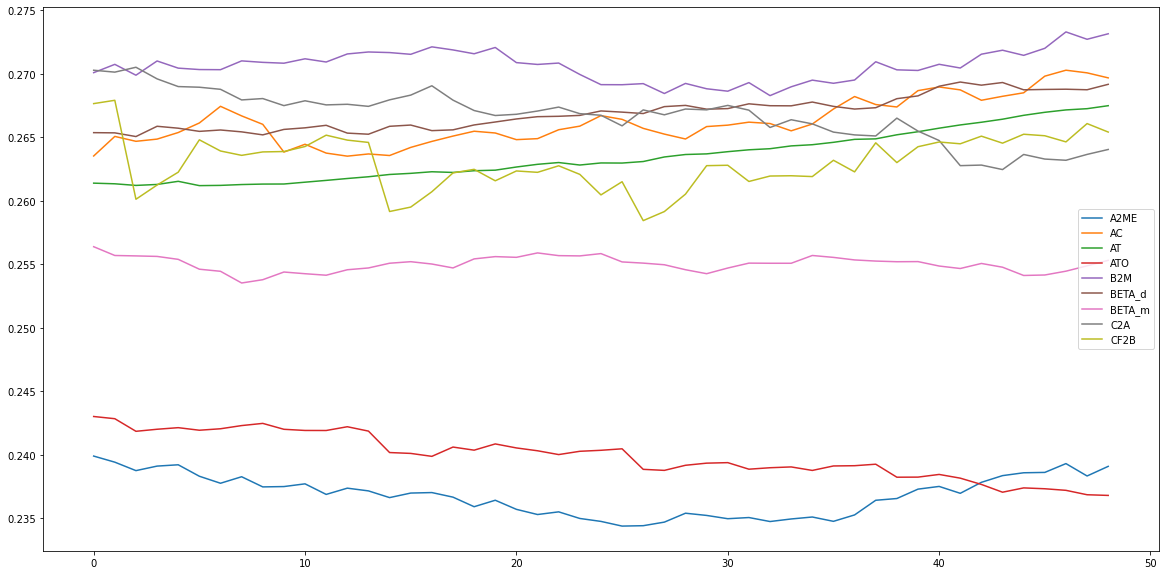

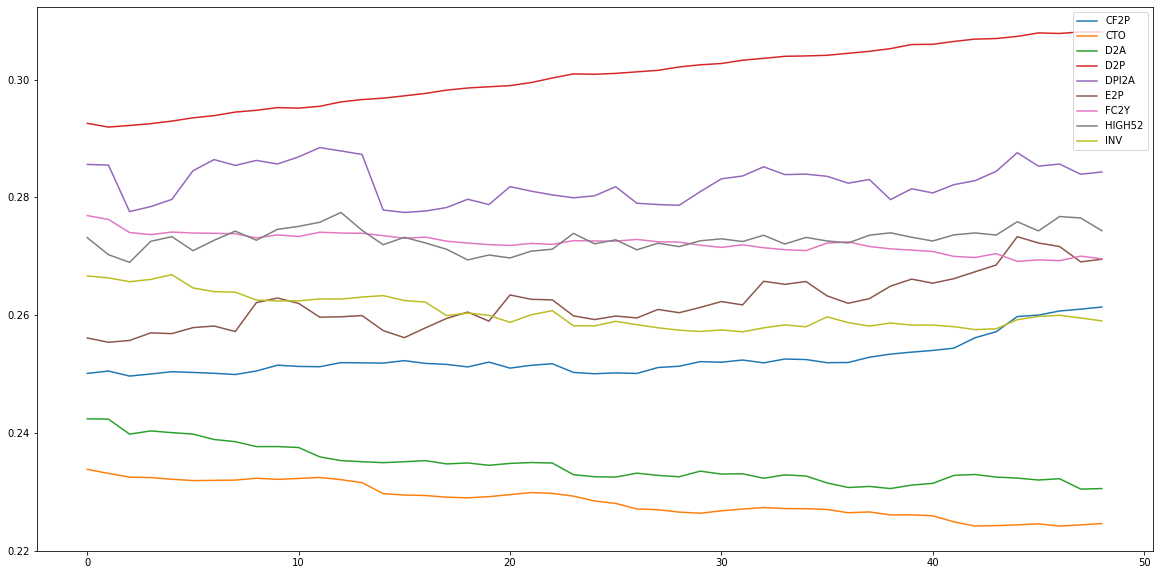

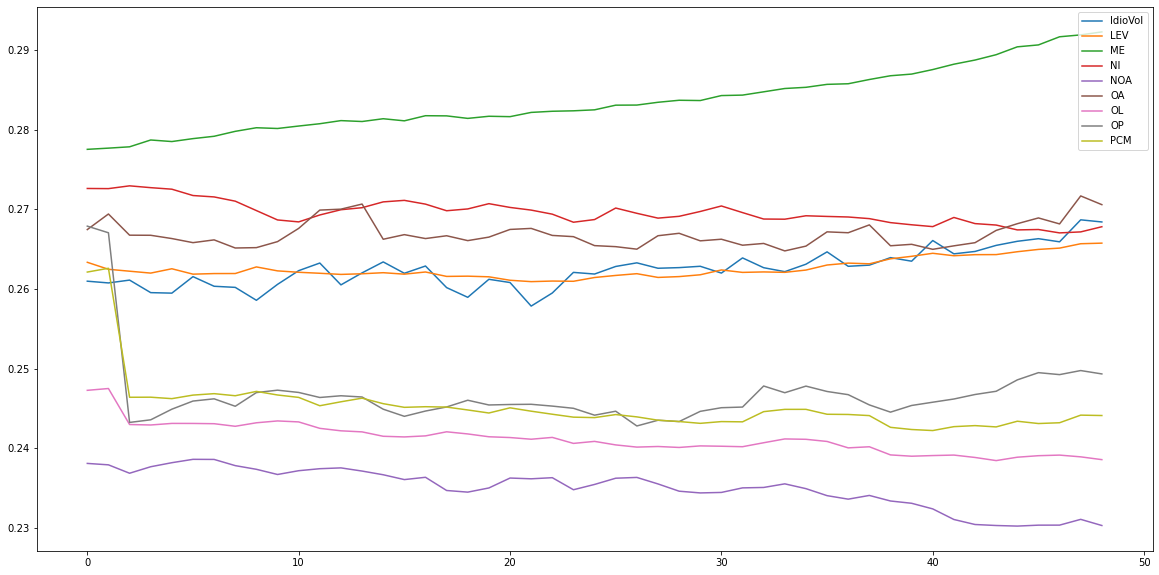

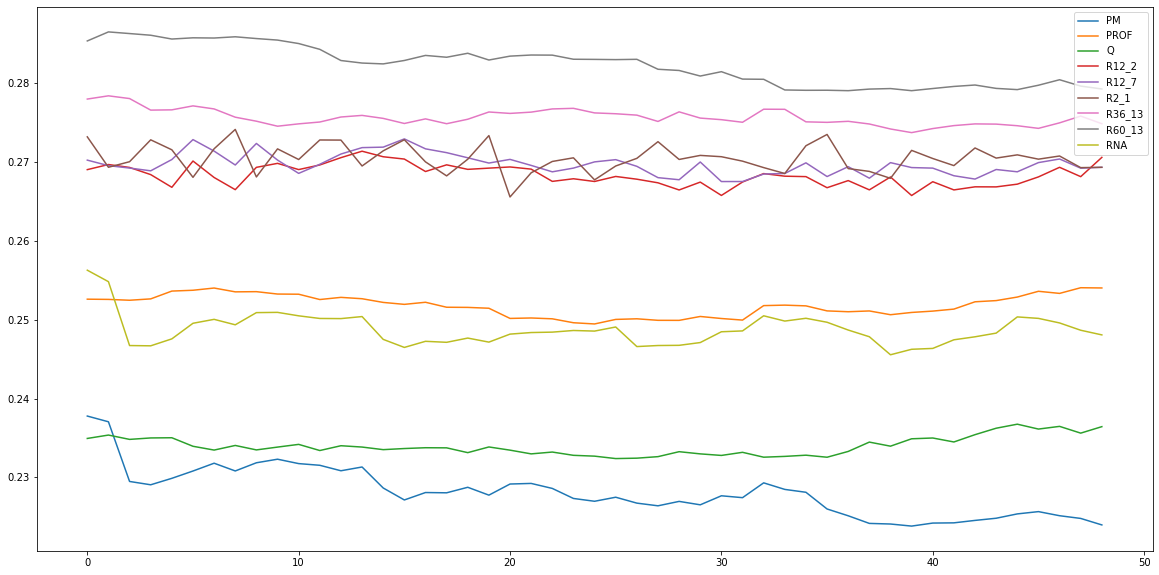

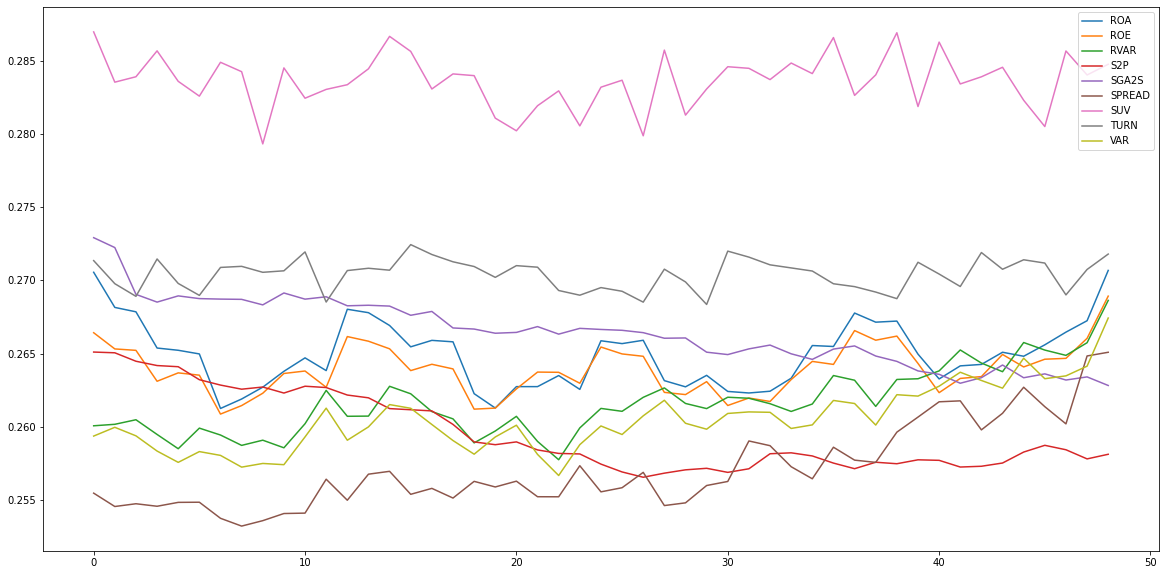

In [239]:
loss_matrix = np.swapaxes(np.array(train_losses), 1,2).reshape((557 * 10, 49, 45))
for j in range(5):
    plt.figure(figsize=(20,10))
    for i in range(j*9, (j+1)*9):
        plt.plot(np.sqrt(np.mean(loss_matrix[:,:,i], axis=0)), label=chars[i])
    plt.legend()
    plt.show()

In [285]:
succ = 0
att = 10000
for i in range(att):
    boys= np.random.randint(low=0, high=365, size=16)
#     print(boys)
    girls= np.random.randint(low=0, high=365, size=16)
#     print(girls)
    if np.any(np.isin(boys, girls)):
        succ += 1


In [286]:
succ / att

0.505